# SCRIPT 2

Plot some figures

In [34]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# Import modules

import numpy as np
import xarray as xr
import pandas as pd
#import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import datetime
import gsw
import os
import glob
import sys
import re
from scipy import stats
import time
from scipy.io import loadmat # to load bathymetry
import plotly 


%load_ext autoreload
%autoreload 2

from setdir import *

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the dataset

In [2]:
fname_full = cat_interim_path('TERIFIC_drifters.nc')
drifters = xr.open_dataset(fname_full)
drifters

<xarray.Dataset>
Dimensions:      (trajectory: 178, obs: 18859)
Coordinates:
  * trajectory   (trajectory) int64 300234066416410 ... 300234068440310
  * obs          (obs) int64 1 2 3 4 5 6 ... 18854 18855 18856 18857 18858 18859
Data variables:
    time         (trajectory, obs) datetime64[ns] ...
    lat          (trajectory, obs) float64 ...
    lon          (trajectory, obs) float64 ...
    SST          (trajectory, obs) float64 ...
    u            (trajectory, obs) float64 ...
    v            (trajectory, obs) float64 ...
    slp          (trajectory, obs) float64 ...
    drogue_cnts  (trajectory, obs) float64 ...
    time_start   (trajectory) datetime64[ns] ...
    deploy_num   (trajectory) int64 ...
Attributes: (12/22)
    ncei_template_version:     NCEI_NetCDF_Trajectory_Template_v2.0
    featureType:               trajectory
    instrument:                Surface velocity profiler (SVP)
    title:                     TERIFIC drifters: Deployed in the subpolar Nor...
    keywords:                  SVP drifters, SVPB drifters
    Conventions:               CF-1.6, ACDD-1.3
    ...                        ...
    time_coverage_start:       2019-12-05
    time_coverage_end:         2022-01-11
    time_coverage_resolution:  hourly
    creator_type:              person
    platform:                  Surface Velocity Profiler
    sea_name:                  Atlantic

# Plot each deployment

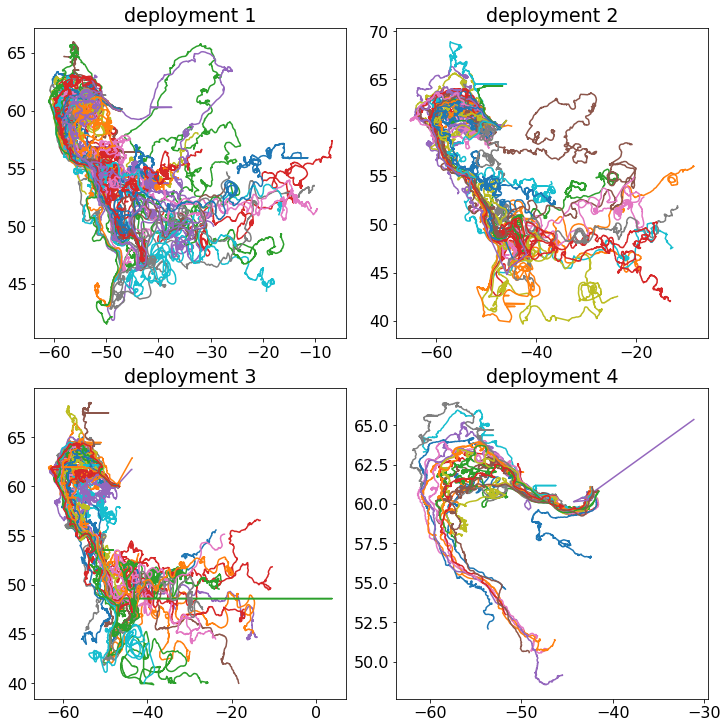

In [35]:
#for i in range(1,1):
fig = plt.figure(constrained_layout=True, figsize=(10,10))
gs = fig.add_gridspec(ncols=2, nrows=2)


for dnum in range(1,5):
    ds1 = drifters.where(drifters["deploy_num"]==dnum, drop=True).copy()

    ax1 = fig.add_subplot(gs[dnum-1])

    for ddo in range(len(ds1['trajectory'])):
        ax1.plot(ds1.lon[ddo,:], ds1.lat[ddo,:])
    ax1.set_title('deployment '+str(dnum))

### Need to check some instances that should've been flagged for too-fast velocity

In [89]:
for ddo in range(len(ds1['trajectory'])):
    maxu = ds1.u[ddo,:].max()
    maxv = ds1.v[ddo,:].max()
    
    if maxu>2:
        print('u'+str(ddo)+': ',str(ds1.trajectory[ddo]))
    if maxv>2:
        print('v'+str(ddo)+': ',str(ds1.trajectory[ddo]))


v6:  <xarray.DataArray 'trajectory' ()>
array(300234068346250)
Coordinates:
    trajectory  int64 300234068346250
v9:  <xarray.DataArray 'trajectory' ()>
array(300234068346740)
Coordinates:
    trajectory  int64 300234068346740
u10:  <xarray.DataArray 'trajectory' ()>
array(300234068347720)
Coordinates:
    trajectory  int64 300234068347720
u17:  <xarray.DataArray 'trajectory' ()>
array(300234068348230)
Coordinates:
    trajectory  int64 300234068348230
v20:  <xarray.DataArray 'trajectory' ()>
array(300234068349630)
Coordinates:
    trajectory  int64 300234068349630
u23:  <xarray.DataArray 'trajectory' ()>
array(300234068349700)
Coordinates:
    trajectory  int64 300234068349700
v23:  <xarray.DataArray 'trajectory' ()>
array(300234068349700)
Coordinates:
    trajectory  int64 300234068349700


(1800.0, 1850.0)

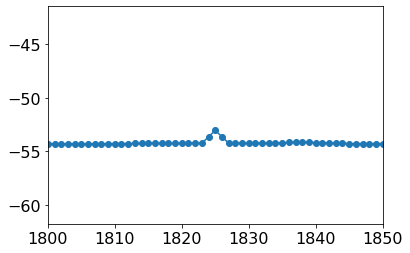

In [88]:
ddo=9
plt.plot(ds1.lon[ddo,:],marker='o')
plt.xlim([1800,1850])

# Trying to assign bathymetry to drifter positions
The interp2d isn't working quite right.  Gives positive bathymetry along the diagonal when it should still be negative (below sea level)

In [46]:
from scipy import interpolate
mfile = 'labsea_66.44W_45.68N_5min'
ds_bathy = xr.open_dataset(cat_proc_path(mfile+'.nc'))

# Use interp to find the bathy nearest a point
lonname = 'lon'
latname = 'lat'

tt = 10
lon1 = ds1[lonname][tt, :].values
lat1 = ds1[latname][tt, :].values

lon = ds_bathy.lon
lat = ds_bathy.lat
da1 = ds_bathy.depth.values
f = interpolate.interp2d(lon, lat, da1, kind='linear')
znew = f(lon1,lat1)
znew1 = znew.diagonal()
znew1.where(np.isnan(lon1)) = np.nan
#plt.plot(znew)
#plt.show()


SyntaxError: cannot assign to function call (2704679951.py, line 19)

(3712, 3712)

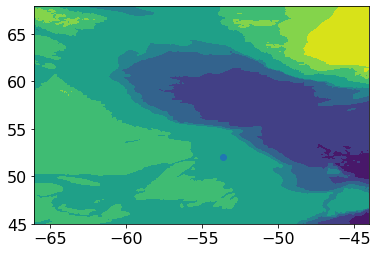

In [71]:
znew2=znew1.copy()
znew2[np.isnan(lon1)] = np.nan 
#plt.plot(znew2)

plt.plot(lon1[3711],lat1[3711],marker='o')
plt.contourf(ds_bathy.lon,ds_bathy.lat,ds_bathy.depth)
#znew2[3711]
znew_subset = znew[:3712,:3712].copy()
znew_subset.shape



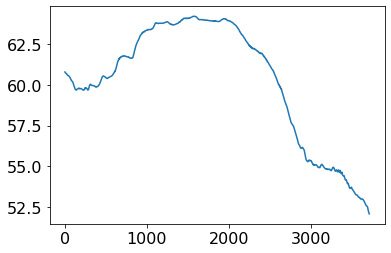

In [74]:
plt.plot(lat1)

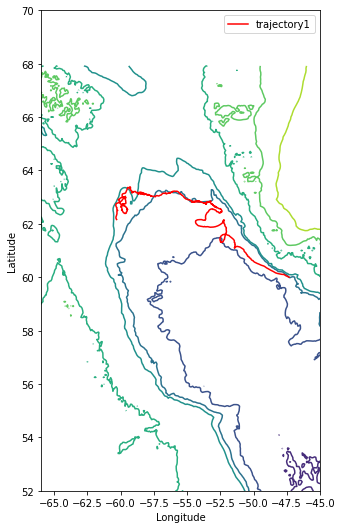

In [23]:

# Set a mercator aspect ratio for maps
# This one is for figure sizes when there's only one axis
def compute_ysize(xsize,lonlim,latlim):
    scale_lon = np.cos(np.mean(latlim)*np.pi/180)
    dlon = lonlim[1]-lonlim[0]
    dlat = latlim[1]-latlim[0]
    ysize = xsize/(dlon*scale_lon)*dlat
    return ysize

# Choose axis limits
latlim = [52, 70]
lonlim = [-66, -45]

axes = plt.subplots(nrows=1, ncols=1)
ax1 = plt.subplot(1,1,1)
ax1.contour(ds_bathy.lon, ds_bathy.lat, ds_bathy.depth)
ax1.set_ylim(latlim)
ax1.set_xlim(lonlim)
fig = plt.gcf()

ax1.plot(lon1,lat1, color='r')
ax1.set_xlabel('Longitude')
ax1.set_ylabel("Latitude")
plt.legend(['trajectory1'])


xsize = 5
ysize = compute_ysize(xsize, lonlim, latlim)

fig.set_size_inches(xsize, ysize)



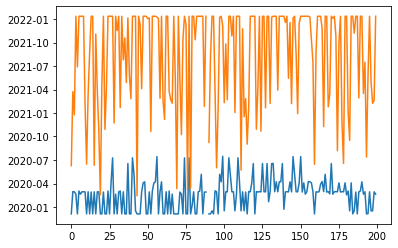

In [63]:
plt.plot(start_time)
plt.plot(end_time)

# Replot as sorted
# https://stackoverflow.com/questions/3382352/equivalent-of-numpy-argsort-in-basic-python

In [14]:
ds_hourly.time.min().values
#ds_hourly.time.max().values

numpy.datetime64('2020-06-15T12:00:00.000000000')

In [ ]:
if 0:

    # ~ ~ print update ~ ~ 
    if len(existing_files) > 0:
        print("Existing raw data files: \n%s\n" % existing_files)
    else:
        sys.exit("No previous raw data files.\n")

    # ~ ~ filenaming convention ~ ~
    # If there are multiple files with raw data (i.e. non-updated datasets), select 
    # the latest one updated.
    # The file names are distinguished by the timestamp appended to the filename 
    # and has <tstamp_strftime> format (see 'user edits' section).
    # The data are cropped such that the last day is fully sampled (spans 0h-23h).
    # The timestamp in the filename is the latest downloaded fully sampled day.

    # Extract the timestamp part of the filename(s) in a list
    tstamp = [date for file in existing_files 
                for date in re.findall("(\d{8})", file)]

    # Convert to datetime and pick the most recent timestamp
    tstamp_date = pd.to_datetime(tstamp, format=tstamp_strftime)
    fname_timestamp = tstamp[tstamp_date.argmax()]

    # Load the raw file with the latest timestamp
    ds_fname = f"{fnames.fname_rawdata}{fname_timestamp}.nc"
    ds_fpath = os.path.join(data_dir, ds_fname)

    print("Opening file: %s\n" % ds_fpath)
    ds_raw = xr.open_dataset(ds_fpath)
